# Uncertainty quantification using "DRIVE: Digital Retinal Images for Vessel Extraction" dataset
 
__author__: Yongchan Kwon

This note shows an example of the use of the method introduced in the paper "Uncertainty quantification using Bayesian neural networks in classification: Application to biomedical segmentation".

This notebook is based on the Walter de Back's amazing notebook https://gitlab.com/wdeback/dl-keras-tutorial/blob/master/notebooks/3-cnn-segment-retina-uncertainty.ipynb I really recommend to see together. 

**Reference**

- J.J. Staal, M.D. Abramoff, M. Niemeijer, M.A. Viergever, B. van Ginneken, "Ridge based vessel segmentation in color images of the retina", IEEE Transactions on Medical Imaging, 2004, vol. 23, pp. 501-509.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os, glob
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
np.random.seed(20180621)

from skimage.external import tifffile # read tiff images
from skimage.io import imread # read gif images
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
import seaborn as sns

from model import *
import utils
import time

plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
print('Backend: ', K.backend())
print('Image_data_format: ', K.image_data_format())
N_train = 200

Backend:  tensorflow
Image_data_format:  channels_last


In [3]:
# load training images
fns = sorted(glob.glob('./input/training/images/*.tif'))
x_train = np.array([tifffile.imread(fn) for fn in fns])

# load test images
fns = sorted(glob.glob('./input/test/images/*.tif'))
x_test = np.array([tifffile.imread(fn) for fn in fns])
print('shape of raw train data: ', x_train.shape)
print('shape of raw test data: ',x_test.shape)

/usr/local/lib/python3.5/dist-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


shape of raw train data:  (20, 584, 565, 3)
shape of raw test data:  (20, 584, 565, 3)


In [4]:
 # load training annotations
fns = sorted(glob.glob('./input/training/1st_manual/*.gif'))
y_train = np.array([imread(fn) for fn in fns]) # read images
y_train = np.expand_dims(y_train, -1) # add channels dimension

# load test annotations
fns = sorted(glob.glob('./input/test/1st_manual/*.gif'))
y_test = np.array([imread(fn) for fn in fns]) # read images
y_test = np.expand_dims(y_test, -1) # add channels dimension
print('train shape:', y_train.shape)
print('test shape:', y_test.shape)

train shape: (20, 584, 565, 1)
test shape: (20, 584, 565, 1)


## Preprecossing

In [5]:
x_train = utils.preprocess(x_train)
x_test = utils.preprocess(x_test)

y_train = utils.preprocess(y_train)
y_test = utils.preprocess(y_test)

min: 0.0, max: 1.0, shape: (20, 584, 565, 3), type: float32
min: 0.0, max: 1.0, shape: (20, 584, 565, 3), type: float32
min: 0.0, max: 1.0, shape: (20, 584, 565, 1), type: float32
min: 0.0, max: 1.0, shape: (20, 584, 565, 1), type: float32


In [6]:
X_train, Y_train = utils.get_random_snippets(x_train, y_train, number=N_train, size=(96,96))
X_test, Y_test = utils.get_random_snippets(x_test, y_test, number=1000, size=(96,96))

print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

X_train shape:  (200, 96, 96, 3)
Y_train shape:  (200, 96, 96, 1)
X_test shape:  (1000, 96, 96, 3)
Y_test shape:  (1000, 96, 96, 1)


<Figure size 1440x1440 with 0 Axes>

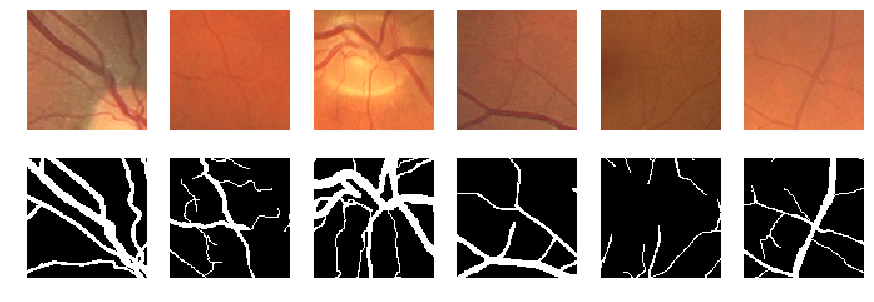

In [7]:
plt.rcParams['figure.figsize'] = [15, 5]
M=6
list_index = np.random.randint(low=0, high=X_train.shape[0], size=M)
plt.figure(figsize=(20,20))
fig, ax = plt.subplots(2,M)
for k, ind in enumerate(list_index):
    ax[0,k].imshow(X_train[ind])
    ax[1,k].imshow(Y_train[ind,:,:,0], cmap='gray')
    
    ax[0,k].axis('off')
    ax[1,k].axis('off')

fig.savefig('./fig/DRIVE_example_200.pdf')

In [8]:
model = UNet(N_filters=16)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', dice_coefficient, precision_smooth, recall_smooth])
print("Number of parameters: ", model.count_params())

Number of parameters:  1115265


In [9]:
batch_size = 32
epochs = 200
info_check_string='./weights/DRIVE_stochastic_sample_200.hdf5'
early_stopping=EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint=ModelCheckpoint(info_check_string, monitor='loss', save_best_only=True)

In [10]:
history = model.fit(X_train, Y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      shuffle=True,
                      verbose=1,
                      validation_split=0.2, # 4 samples are used for a validation set
                      callbacks=[early_stopping, model_checkpoint]) 

Train on 160 samples, validate on 40 samples
Epoch 1/200
160/160 [==============================] - 4s 25ms/step - loss: 0.8637 - binary_accuracy: 0.5144 - dice_coefficient: 0.1920 - precision_smooth: 0.1182 - recall_smooth: 0.5144 - val_loss: 1.0152 - val_binary_accuracy: 0.5498 - val_dice_coefficient: 0.1801 - val_precision_smooth: 0.1092 - val_recall_smooth: 0.5184
Epoch 2/200
160/160 [==============================] - 0s 3ms/step - loss: 0.7672 - binary_accuracy: 0.5296 - dice_coefficient: 0.2024 - precision_smooth: 0.1246 - recall_smooth: 0.5389 - val_loss: 0.6771 - val_binary_accuracy: 0.6773 - val_dice_coefficient: 0.1743 - val_precision_smooth: 0.1115 - val_recall_smooth: 0.4032
Epoch 3/200
160/160 [==============================] - 0s 3ms/step - loss: 0.7358 - binary_accuracy: 0.5409 - dice_coefficient: 0.2069 - precision_smooth: 0.1277 - recall_smooth: 0.5464 - val_loss: 0.6660 - val_binary_accuracy: 0.6787 - val_dice_coefficient: 0.1832 - val_precision_smooth: 0.1164 - val_r

160/160 [==============================] - 0s 3ms/step - loss: 0.3119 - binary_accuracy: 0.9266 - dice_coefficient: 0.4405 - precision_smooth: 0.3101 - recall_smooth: 0.7633 - val_loss: 0.2464 - val_binary_accuracy: 0.9394 - val_dice_coefficient: 0.4179 - val_precision_smooth: 0.3222 - val_recall_smooth: 0.5964
Epoch 27/200
160/160 [==============================] - 0s 3ms/step - loss: 0.3037 - binary_accuracy: 0.9298 - dice_coefficient: 0.4518 - precision_smooth: 0.3207 - recall_smooth: 0.7685 - val_loss: 0.2620 - val_binary_accuracy: 0.9334 - val_dice_coefficient: 0.4010 - val_precision_smooth: 0.3152 - val_recall_smooth: 0.5530
Epoch 28/200
160/160 [==============================] - 0s 3ms/step - loss: 0.2996 - binary_accuracy: 0.9304 - dice_coefficient: 0.4448 - precision_smooth: 0.3177 - recall_smooth: 0.7486 - val_loss: 0.2422 - val_binary_accuracy: 0.9401 - val_dice_coefficient: 0.4316 - val_precision_smooth: 0.3350 - val_recall_smooth: 0.6096
Epoch 29/200
160/160 [=============

160/160 [==============================] - 0s 3ms/step - loss: 0.1842 - binary_accuracy: 0.9520 - dice_coefficient: 0.5803 - precision_smooth: 0.4777 - recall_smooth: 0.7445 - val_loss: 0.1908 - val_binary_accuracy: 0.9409 - val_dice_coefficient: 0.5021 - val_precision_smooth: 0.5048 - val_recall_smooth: 0.5011
Epoch 52/200
160/160 [==============================] - 0s 3ms/step - loss: 0.1789 - binary_accuracy: 0.9530 - dice_coefficient: 0.5957 - precision_smooth: 0.4923 - recall_smooth: 0.7563 - val_loss: 0.1749 - val_binary_accuracy: 0.9470 - val_dice_coefficient: 0.5521 - val_precision_smooth: 0.5319 - val_recall_smooth: 0.5745
Epoch 53/200
160/160 [==============================] - 0s 3ms/step - loss: 0.1786 - binary_accuracy: 0.9528 - dice_coefficient: 0.5923 - precision_smooth: 0.4922 - recall_smooth: 0.7534 - val_loss: 0.1792 - val_binary_accuracy: 0.9440 - val_dice_coefficient: 0.5359 - val_precision_smooth: 0.5395 - val_recall_smooth: 0.5339
Epoch 54/200
160/160 [=============

160/160 [==============================] - 0s 3ms/step - loss: 0.1372 - binary_accuracy: 0.9581 - dice_coefficient: 0.6718 - precision_smooth: 0.5993 - recall_smooth: 0.7681 - val_loss: 0.1581 - val_binary_accuracy: 0.9498 - val_dice_coefficient: 0.6167 - val_precision_smooth: 0.6384 - val_recall_smooth: 0.5969
Epoch 77/200
160/160 [==============================] - 0s 3ms/step - loss: 0.1363 - binary_accuracy: 0.9583 - dice_coefficient: 0.6739 - precision_smooth: 0.6051 - recall_smooth: 0.7646 - val_loss: 0.1556 - val_binary_accuracy: 0.9501 - val_dice_coefficient: 0.6071 - val_precision_smooth: 0.6238 - val_recall_smooth: 0.5919
Epoch 78/200
160/160 [==============================] - 0s 3ms/step - loss: 0.1336 - binary_accuracy: 0.9588 - dice_coefficient: 0.6784 - precision_smooth: 0.6086 - recall_smooth: 0.7678 - val_loss: 0.1508 - val_binary_accuracy: 0.9510 - val_dice_coefficient: 0.6250 - val_precision_smooth: 0.6369 - val_recall_smooth: 0.6140
Epoch 79/200
160/160 [=============

In [11]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss, acc, dice, precision, recall):', score)

1000/1000 [==============================] - 1s 1ms/step
Test loss, acc, dice, precision, recall): [0.17213940978050232, 0.9460738945007324, 0.6654438090324402, 0.7034364252090454, 0.6318319554328918]


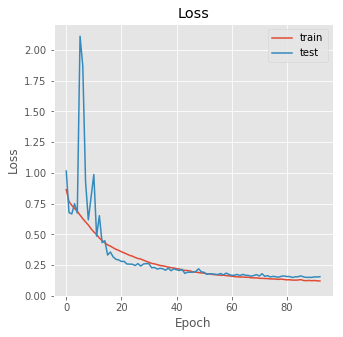

In [12]:
 def plot_history(history, validation=False):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), sharex=True)
    #fig.tight_layout()
    # plot history for loss
    ax.plot(history.history['loss'])
    if validation:
        ax.plot(history.history['val_loss'])
    ax.set_title('Loss')
    ax.set_ylabel('Loss')
    ax.set_ylim(bottom=0.)
    ax.set_xlabel('Epoch')
    ax.legend(['train', 'test'])
    
    plt.savefig('./fig/loss_curve_200.pdf')
    
plot_history(history, validation=True)

# Bayesian neural network: stochastic feed forward

In [13]:
# It takes a time !! 
num = len(X_test)
list_stochastic_feed_forwards = [3,5,10,15,20,30]
result_dict = {}
for ind, num_stochastic_T in enumerate(list_stochastic_feed_forwards):
    start = time.time()
    alea_list = []
    epis_list = []
    dice_list = []
    for i in range(num):
        image = X_test[i]
        gt    = Y_test[i]
        prediction, aleatoric, epistemic, scores = utils.predict(model, image, gt, T=num_stochastic_T)
        alea_list.append(np.mean(aleatoric))
        epis_list.append(np.mean(epistemic))
        dice_list.append(scores[0])
    
    end = time.time()
    print('-'*30)
    print('T: ', num_stochastic_T)
    print('Exec time per prediction = {:.3f}'.format((end-start)/num))
    print('aleatoric: ', np.mean(alea_list), np.std(alea_list))
    print('epistemic: ', np.mean(epis_list), np.std(epis_list))    
    print('Dice: ', np.mean(dice_list), np.std(dice_list))  
    print('-'*30)
    
    result_dict.update({ '{}'.format(str(num_stochastic_T)) : 
    [num_stochastic_T, (end-start)/num,
     np.mean(alea_list), np.std(alea_list),
     np.mean(epis_list), np.std(epis_list),
     np.mean(dice_list), np.std(dice_list)]} )

------------------------------
T:  3
Exec time per prediction = 0.038
aleatoric:  0.028299022 0.006322003
epistemic:  0.0030602918 0.0015752879
Dice:  0.9460615234375 0.025290359707225176
------------------------------
------------------------------
T:  5
Exec time per prediction = 0.055
aleatoric:  0.02828895 0.006333298
epistemic:  0.0036781365 0.0018786569
Dice:  0.9461230466961861 0.025306064084749846
------------------------------
------------------------------
T:  10
Exec time per prediction = 0.100
aleatoric:  0.028308872 0.0063346787
epistemic:  0.0041251346 0.0020697091
Dice:  0.9460942927002907 0.02525111498869854
------------------------------
------------------------------
T:  15
Exec time per prediction = 0.144
aleatoric:  0.028295929 0.0063197743
epistemic:  0.004285844 0.0021647816
Dice:  0.9462431647777557 0.02510089055662471
------------------------------
------------------------------
T:  20
Exec time per prediction = 0.189
aleatoric:  0.028286744 0.0063078403
epistem

In [14]:
results = np.zeros((5, len(list_stochastic_feed_forwards)))
for ind, num_stochastic_T in enumerate(list_stochastic_feed_forwards):
    results[:, ind] = result_dict[str(num_stochastic_T)][1:6]

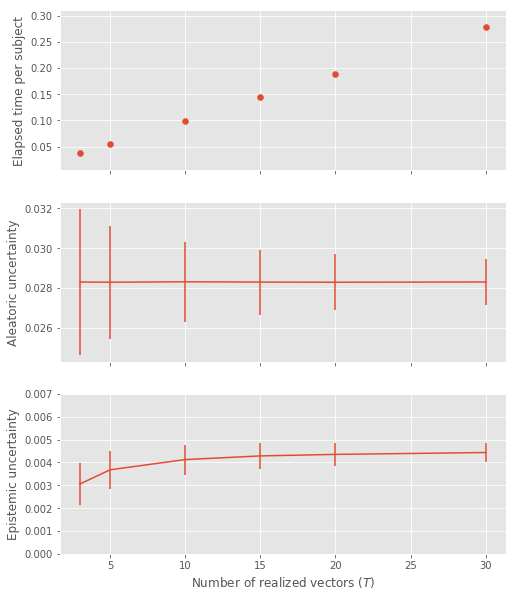

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)
# plot history for loss
ax[0].scatter(list_stochastic_feed_forwards,results[0])
ax[0].set_ylabel('Elapsed time per subject')
ax[1].errorbar(list_stochastic_feed_forwards,results[1], yerr=results[2]/np.sqrt(list_stochastic_feed_forwards))
ax[1].set_ylabel('Aleatoric uncertainty')
ax[2].errorbar(list_stochastic_feed_forwards,results[3], yerr=results[4]/np.sqrt(list_stochastic_feed_forwards))
ax[2].set_ylabel('Epistemic uncertainty')
ax[2].set_xlabel('Number of realized vectors ($T$)')
ax[2].set_ylim(0.00,0.007)
plt.savefig('./fig/elapsed_time_vs_feed_200.pdf')

In [20]:
# Case T = 5
num = len(X_test)
start = time.time()
list_alea = []
list_epis = []
for i in range(num):
    image = X_test[i]
    gt    = Y_test[i]
    prediction, aleatoric, epistemic, scores = utils.predict(model, image, gt, T=5)
    list_alea.append(aleatoric.reshape(-1))
    list_epis.append(epistemic.reshape(-1))

end = time.time()
print('Exec time per prediction = {:.3f}'.format((end-start)/num))
print('aleatoric: ', np.mean(list_alea))
print('epistemic: ', np.mean(list_epis))


Exec time per prediction = 0.055
aleatoric:  0.028303843
epistemic:  0.0036727092


In [21]:
list_alea = np.hstack(list_alea)
list_epis = np.hstack(list_epis)

print('aleatoric mean: ', np.mean(list_alea))
print('epistemic mean: ', np.mean(list_epis))

aleatoric mean:  0.028303843
epistemic mean:  0.0036727092


# Bivariate density plot for aleatoric and epistemic uncertainties (Figure 5)

In [22]:
threshold = np.percentile(list_alea, 99)
alea_index = (list_alea > threshold)

/usr/local/lib/python3.5/dist-packages/seaborn/distributions.py:645: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


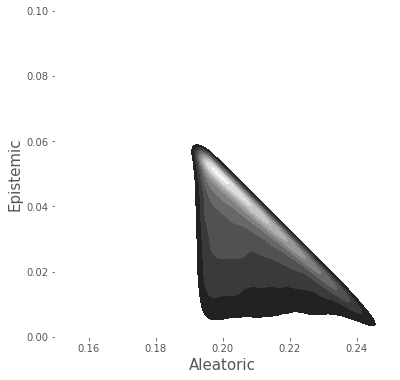

In [23]:
plt.figure(figsize=(6,6))
data = np.vstack([list_alea[alea_index], list_epis[alea_index]]).T
ax = sns.kdeplot(data, shade = True, cmap = "gray", cbar=False)
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)
ax.set_xlabel('Aleatoric', fontsize = 15)
ax.set_ylabel('Epistemic', fontsize = 15)
ax.set_xlim(0.15, 0.25)
ax.set_ylim(0, 0.1)
plt.savefig('./fig/epis_vs_alea_200.pdf')

# Conditional expectation of epistemic uncertainty (Table 5)

In [24]:
threshold_99 = np.percentile(list_alea, 99.)
threshold_995 = np.percentile(list_alea, 99.5)
threshold_999 = np.percentile(list_alea, 99.9)
threshold_9995 = np.percentile(list_alea, 99.95)
print(threshold_99, threshold_995, threshold_999, threshold_9995)
# alea_index = (list_alea > threshold)

0.19313378870487208 0.20685287117958118 0.22729325330257422 0.2326981746330904


In [25]:
# Table 5 in the paper.
print('conditional expectation of epistemic')
print(
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.05) and (list_alea[i] < 0.1)]),
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.1) and (list_alea[i] < 0.15)]),
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.15) and (list_alea[i] < 0.2)]),
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.2) and (list_alea[i] < 0.25)])
    )

conditional expectation of epistemic
0.011590595 0.037911735 0.044455074 0.026015565
